# Research how many values are missing for power generation in the different data splits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'raw_data/sdwpf_turb_information.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

   TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  \
0       1    1   00:00   NaN   NaN    NaN    NaN    NaN   NaN   NaN   NaN   
1       1    1   00:10  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0   
2       1    1   00:20  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0   
3       1    1   00:30  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0   
4       1    1   00:40  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0   

   Prtv    Patv  
0   NaN     NaN  
1 -0.25  494.66  
2 -0.24  509.76  
3 -0.26  542.53  
4 -0.23  509.36  


In [18]:
total_zero_values = (df == 0).sum().sum()
zero_values_patv = (df['Patv'] == 0).sum()
total_values = df.size
total_values_patv = df['Patv'].size

percentage_zero_values = (total_zero_values / total_values) * 100
percentage_zero_values_patv = (zero_values_patv / total_values_patv) * 100

# Print the results
print(f"Zero values in 'Patv' column: {zero_values_patv}")
print(f"Total number of values in 'Patv' column: {total_values_patv}")
print(f"Percentage of zero values in 'Patv' column: {percentage_zero_values_patv:.2f}%")

print(f"Total number of zero values in the dataset: {total_zero_values}")
print(f"Total number of values in the dataset: {total_values}")
print(f"Percentage of zero values in the dataset: {percentage_zero_values:.2f}%")


Zero values in 'Patv' column: 1379764
Total number of values in 'Patv' column: 4678002
Percentage of zero values in 'Patv' column: 29.49%
Total number of zero values in the dataset: 9853366
Total number of values in the dataset: 70170030
Percentage of zero values in the dataset: 14.04%


In [19]:
# Define the split ratios
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First, split into train and temp (temp will be further split into val and test)
train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)

# Then, split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + val_size), random_state=42)

# Check the sizes of the splits
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")


Training set size: (3274601, 15)
Validation set size: (701700, 15)
Test set size: (701701, 15)


In [20]:
# Check for missing values in the 'Patv' column of the training set
train_missing_values_patv = train_df['Patv'].isnull().sum()
print("Missing values in 'Patv' column in training set:", train_missing_values_patv)

# Check for missing values in the 'Patv' column of the validation set
val_missing_values_patv = val_df['Patv'].isnull().sum()
print("Missing values in 'Patv' column in validation set:", val_missing_values_patv)

# Check for missing values in the 'Patv' column of the test set
test_missing_values_patv = test_df['Patv'].isnull().sum()
print("Missing values in 'Patv' column in test set:", test_missing_values_patv)


Missing values in 'Patv' column in training set: 0
Missing values in 'Patv' column in validation set: 0
Missing values in 'Patv' column in test set: 0


In [2]:

# Create a copy of the original dataframe to apply fixes
df_fixed = df.copy()

# Step 1: Replace negative Patv values with 0
df_fixed['Patv'] = df_fixed['Patv'].apply(lambda x: max(x, 0))

# Step 2: Handle missing values by setting Patv to 0
df_fixed['Patv'].fillna(0, inplace=True)

# Step 3: Identify unknown values
# Condition 1: If Patv <= 0 and Wspd > 2.5
unknown_condition_1 = (df_fixed['Patv'] <= 0) & (df_fixed['Wspd'] > 2.5)

# Condition 2: If Pab1 > 89 or Pab2 > 89 or Pab3 > 89
unknown_condition_2 = (df_fixed['Pab1'] > 89) | (df_fixed['Pab2'] > 89) | (df_fixed['Pab3'] > 89)

# Combine unknown conditions
df_fixed['Unknown'] = unknown_condition_1 | unknown_condition_2

# Step 4: Identify abnormal values
# Condition 1: Ndir not in range [-720, 720]
abnormal_condition_1 = (df_fixed['Ndir'] < -720) | (df_fixed['Ndir'] > 720)

# Condition 2: Wdir not in range [-180, 180]
abnormal_condition_2 = (df_fixed['Wdir'] < -180) | (df_fixed['Wdir'] > 180)

# Combine abnormal conditions
df_fixed['Abnormal'] = abnormal_condition_1 | abnormal_condition_2

# Set Patv to 0 for unknown and abnormal values
df_fixed.loc[df_fixed['Unknown'] | df_fixed['Abnormal'], 'Patv'] = 0

# Drop the helper columns
df_fixed.drop(columns=['Unknown', 'Abnormal'], inplace=True)

# Count and print the total number of missing values, unknown values, and abnormal values
total_missing_values = df.isna().sum().sum()
unknown_condition_1_count = unknown_condition_1.sum()
unknown_condition_2_count = unknown_condition_2.sum()
total_unknown_count = unknown_condition_1_count + unknown_condition_2_count
abnormal_condition_1_count = abnormal_condition_1.sum()
abnormal_condition_2_count = abnormal_condition_2.sum()
total_abnormal_count = abnormal_condition_1_count + abnormal_condition_2_count

# Calculate the percentages
total_values = df.size
percentage_unknown_values = (total_unknown_count / total_values) * 100
percentage_abnormal_values = (total_abnormal_count / total_values) * 100

# Print the results
print(f"Total number of missing values: {total_missing_values}")
print(f"Unknown values identified (Condition 1): {unknown_condition_1_count}")
print(f"Unknown values identified (Condition 2): {unknown_condition_2_count}")
print(f"Total unknown values: {total_unknown_count}")
print(f"Percentage of unknown values: {percentage_unknown_values:.2f}%")
print(f"Abnormal values identified (Condition 1): {abnormal_condition_1_count}")
print(f"Abnormal values identified (Condition 2): {abnormal_condition_2_count}")
print(f"Total abnormal values: {total_abnormal_count}")
print(f"Percentage of abnormal values: {percentage_abnormal_values:.2f}%")

# Save the fixed data to a new CSV file
df_fixed.to_csv('raw_data/cleaned_turbine_information.csv', index=False)

print("Data cleaned and saved to 'fixed_turn_information.csv'")


Total number of missing values: 495180
Unknown values identified (Condition 1): 299094
Unknown values identified (Condition 2): 984595
Total unknown values: 1283689
Percentage of unknown values: 2.09%
Abnormal values identified (Condition 1): 49
Abnormal values identified (Condition 2): 78
Total abnormal values: 127
Percentage of abnormal values: 0.00%
Data cleaned and saved to 'fixed_turn_information.csv'


In [22]:
import pandas as pd

# Read the cleaned data from the CSV file
df_clean = pd.read_csv('cleaned_turbine_information.csv')

total_zero_values = (df_clean == 0).sum().sum()

zero_values_patv = (df_clean['Patv'] == 0).sum()
total_values = df_clean.size

total_values_patv = df_clean['Patv'].size
percentage_zero_values = (total_zero_values / total_values) * 100
percentage_zero_values_patv = (zero_values_patv / total_values_patv) * 100

# Print the results
print(f"Zero values in 'Patv' column: {zero_values_patv}")
print(f"Total number of values in 'Patv' column: {total_values_patv}")
print(f"Percentage of zero values in 'Patv' column: {percentage_zero_values_patv:.2f}%")

print(f"Total number of zero values in the dataset: {total_zero_values}")
print(f"Total number of values in the dataset: {total_values}")
print(f"Percentage of zero values in the dataset: {percentage_zero_values:.2f}%")

Zero values in 'Patv' column: 1379793
Total number of values in 'Patv' column: 4678002
Percentage of zero values in 'Patv' column: 29.50%
Total number of zero values in the dataset: 1579631
Total number of values in the dataset: 60814026
Percentage of zero values in the dataset: 2.60%


In [24]:
# Define the split ratios
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First, split into train and temp (temp will be further split into val and test)
train_df, temp_df = train_test_split(df_clean, train_size=train_size, random_state=42)

# Then, split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + val_size), random_state=42)

# Check the sizes of the splits
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

# Define a function to calculate the percentage of zero values
def zero_percentage(series):
    zero_count = (series == 0).sum()
    total_count = series.size
    return (zero_count / total_count) * 100

# Calculate and print the percentage of zero values in the 'Patv' column for each dataset split
train_zero_percentage_patv = zero_percentage(train_df['Patv'])
print("Percentage of zero values in 'Patv' column in training set:", train_zero_percentage_patv)

val_zero_percentage_patv = zero_percentage(val_df['Patv'])
print("Percentage of zero values in 'Patv' column in validation set:", val_zero_percentage_patv)

test_zero_percentage_patv = zero_percentage(test_df['Patv'])
print("Percentage of zero values in 'Patv' column in test set:", test_zero_percentage_patv)


Training set size: (3274601, 13)
Validation set size: (701700, 13)
Test set size: (701701, 13)
Percentage of zero values in 'Patv' column in training set: 29.49024934640892
Percentage of zero values in 'Patv' column in validation set: 29.575032064985034
Percentage of zero values in 'Patv' column in test set: 29.439462107079795


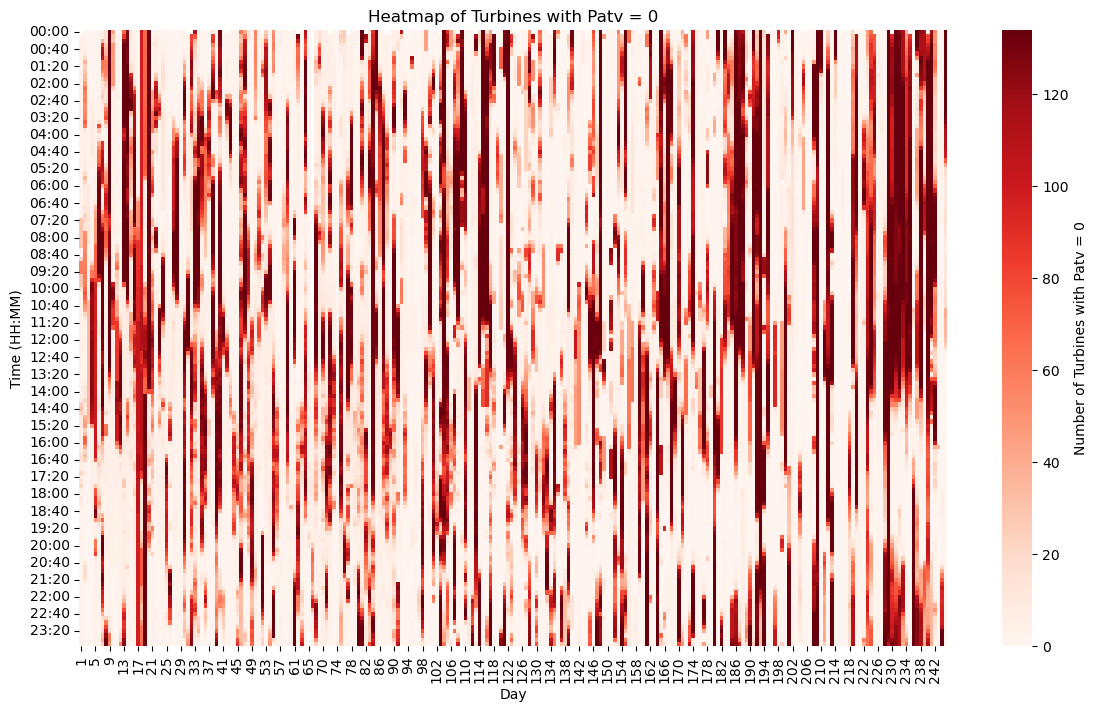

In [29]:
import numpy as np
import seaborn as sns

# Create a pivot table to count the number of turbines with 'Patv' equal to 0 for each day and time
pivot_table = df_clean.pivot_table(index='Tmstamp', columns='Day', values='Patv', aggfunc=lambda x: np.sum(x == 0))

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='Reds', cbar_kws={'label': 'Number of Turbines with Patv = 0'})
plt.xlabel('Day')
plt.ylabel('Time (HH:MM)')
plt.title('Heatmap of Turbines with Patv = 0')
plt.show()


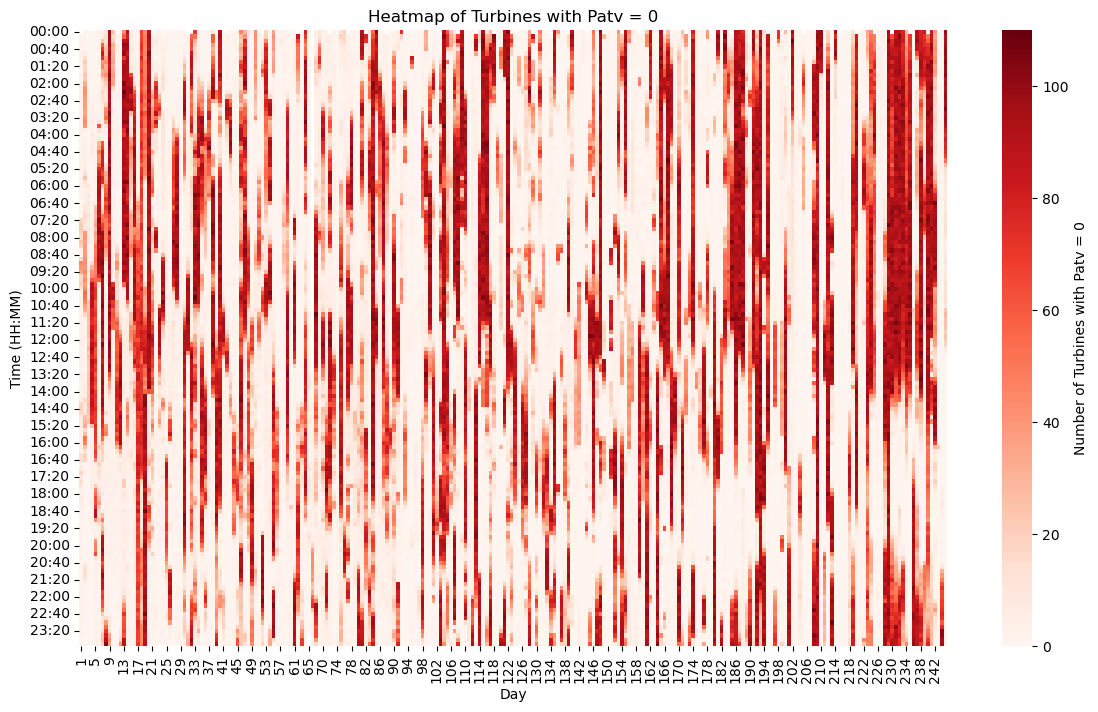

In [30]:
import numpy as np
import seaborn as sns

# Create a pivot table to count the number of turbines with 'Patv' equal to 0 for each day and time
pivot_table = train_df.pivot_table(index='Tmstamp', columns='Day', values='Patv', aggfunc=lambda x: np.sum(x == 0))

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='Reds', cbar_kws={'label': 'Number of Turbines with Patv = 0'})
plt.xlabel('Day')
plt.ylabel('Time (HH:MM)')
plt.title('Heatmap of Turbines with Patv = 0')
plt.show()


In [43]:
df_clean['Counter'] = (df_clean['Day'] - 1) * (24 * 6) + df_clean.groupby('Day').cumcount() + 1
print(df_clean)

         TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  \
0             1    1   00:10  6.17 -3.99  30.73  41.80   25.92  1.00  1.00   
1             1    1   00:20  6.27 -2.18  30.60  41.63   20.91  1.00  1.00   
2             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00   
3             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00   
4             1    1   00:50  6.10 -1.03  30.47  41.22   20.91  1.00  1.00   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   
4677997     134  245   23:10  7.79  2.80  -0.07   3.95  216.51  6.03  6.03   
4677998     134  245   23:20  8.06  4.39   0.23   3.94  216.51  5.81  5.81   
4677999     134  245   23:30  8.08  2.28  -0.16   4.15  216.51  0.68  0.68   
4678000     134  245   23:40  8.46  0.80  -0.14   4.32  216.51  0.02  0.02   
4678001     134  245   23:50  8.68  0.52  -0.06   4.39  216.51  0.01  0.01   

         Pab3    Prtv     Patv  Time_minutes  Counter  
0      

In [59]:
# Define a function to check if all turbines have a Patv value of 0 for a given day and timestamp
def check_all_patv_zero(df, day, timestamp):
    filtered_df = df[(df['Day'] == day) & (df['Tmstamp'] == timestamp)]
    if (filtered_df['Patv'] == 0).all():
        print(f"ZERO: Day: {day}, Timestamp: {timestamp}")
        return (day, timestamp)
    return None

# List to store moments where all turbines have a Patv value of 0
moments_all_patv_zero = []

# Iterate through each unique day and timestamp
for day in df_clean['Day'].unique():
    for timestamp in df_clean['Tmstamp'].unique():
        print(f"Day: {day}, Timestamp: {timestamp}")
        result = check_all_patv_zero(df_clean, day, timestamp)
        if result:
            moments_all_patv_zero.append(result)

# Print the list of moments where all turbines have a Patv value of 0
print("Moments where all turbines have a Patv value of 0:")
print(moments_all_patv_zero)


Day: 1, Timestamp: 00:10
Day: 1, Timestamp: 00:20
Day: 1, Timestamp: 00:30
Day: 1, Timestamp: 00:40
Day: 1, Timestamp: 00:50
Day: 1, Timestamp: 01:00
Day: 1, Timestamp: 01:10
Day: 1, Timestamp: 01:20
Day: 1, Timestamp: 01:30
Day: 1, Timestamp: 01:40
Day: 1, Timestamp: 01:50
Day: 1, Timestamp: 02:00
Day: 1, Timestamp: 02:10
Day: 1, Timestamp: 02:20
Day: 1, Timestamp: 02:30
Day: 1, Timestamp: 02:40
Day: 1, Timestamp: 02:50
Day: 1, Timestamp: 03:00
Day: 1, Timestamp: 03:10
Day: 1, Timestamp: 03:20
Day: 1, Timestamp: 03:30
Day: 1, Timestamp: 03:40
Day: 1, Timestamp: 03:50
Day: 1, Timestamp: 04:00
Day: 1, Timestamp: 04:10
Day: 1, Timestamp: 04:20
Day: 1, Timestamp: 04:30
Day: 1, Timestamp: 04:40
Day: 1, Timestamp: 04:50
Day: 1, Timestamp: 05:00
Day: 1, Timestamp: 05:10
Day: 1, Timestamp: 05:20
Day: 1, Timestamp: 05:30
Day: 1, Timestamp: 05:40
Day: 1, Timestamp: 05:50
Day: 1, Timestamp: 06:00
Day: 1, Timestamp: 06:10
Day: 1, Timestamp: 06:20
Day: 1, Timestamp: 06:30
Day: 1, Timestamp: 06:40


KeyboardInterrupt: 

In [66]:
# Filter the dataframe to include only rows where 'Patv' is not zero
non_zero_patv_df = df_clean[df_clean['Patv'] != 0]

# Group by 'Day' and 'Tmstamp' and count the number of rows
grouped_counts = non_zero_patv_df.groupby(['Day', 'Tmstamp']).size().reset_index(name='row_count')
# Total number of turbines
total_turbines = 134

# Filter the grouped counts dataframe to include only rows where row_count equals total_turbines
moments_all_patv_non_zero = grouped_counts[grouped_counts['row_count'] == total_turbines][['Day', 'Tmstamp']]

# Print the list of moments where all turbines have a 'Patv' value of 0
print("Moments where all turbines have a 'Patv' value of non_zero:")
print(moments_all_patv_non_zero)


Moments where all turbines have a 'Patv' value of non_zero:
       Day Tmstamp
273      2   21:40
274      2   21:50
275      2   22:00
276      2   22:10
277      2   22:20
...    ...     ...
31447  245   22:50
31448  245   23:00
31449  245   23:10
31451  245   23:30
31452  245   23:40

[2885 rows x 2 columns]


In [67]:
# Convert the 'Tmstamp' column to datetime format
moments_all_patv_zero['Tmstamp'] = pd.to_datetime(moments_all_patv_zero['Tmstamp'])

# Sort the dataframe by 'Day' and 'Tmstamp'
moments_all_patv_zero_sorted = moments_all_patv_zero.sort_values(by=['Day', 'Tmstamp'])

# Initialize variables to keep track of the longest sequence
current_sequence_length = 1
longest_sequence_length = 1
longest_sequence_start_day = moments_all_patv_zero_sorted.iloc[0]['Day']
longest_sequence_start_time = moments_all_patv_zero_sorted.iloc[0]['Tmstamp']

# Iterate through the sorted dataframe to find the longest sequence
for i in range(1, len(moments_all_patv_zero_sorted)):
    current_day = moments_all_patv_zero_sorted.iloc[i]['Day']
    current_time = moments_all_patv_zero_sorted.iloc[i]['Tmstamp']
    previous_day = moments_all_patv_zero_sorted.iloc[i - 1]['Day']
    previous_time = moments_all_patv_zero_sorted.iloc[i - 1]['Tmstamp']
    
    # Check if the current timestamp continues the sequence
    if (current_day == previous_day and current_time == previous_time + pd.Timedelta(minutes=10)) or \
       (current_day == previous_day + 1 and current_time == pd.Timestamp(2000, 1, 1, 0, 0)):
        current_sequence_length += 1
    else:
        # Update the longest sequence if the current sequence is longer
        if current_sequence_length > longest_sequence_length:
            longest_sequence_length = current_sequence_length
            longest_sequence_start_day = moments_all_patv_zero_sorted.iloc[i - current_sequence_length + 1]['Day']
            longest_sequence_start_time = moments_all_patv_zero_sorted.iloc[i - current_sequence_length + 1]['Tmstamp']
        # Reset the current sequence length
        current_sequence_length = 1

# Print the longest sequence information
print("Longest consecutive sequence:")
print(f"Start Day: {longest_sequence_start_day}, Start Time: {longest_sequence_start_time}")
print(f"Length: {longest_sequence_length} timestamps")


/var/folders/f9/f489rvfn4hsdfx4c91m6h1b40000gn/T/ipykernel_72492/1694623132.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  moments_all_patv_zero['Tmstamp'] = pd.to_datetime(moments_all_patv_zero['Tmstamp'])


Longest consecutive sequence:
Start Day: 239, Start Time: 2024-06-02 12:10:00
Length: 30 timestamps


In [10]:
import pandas as pd

# Load the dataset
df = pd.read_csv('raw_data/cleaned_turbine_information.csv')

# Ensure the dataset is sorted by TurbID, Day, and Tmstamp
df = df.sort_values(by=['TurbID', 'Day', 'Tmstamp'])

# Add a new column 'TimeCounter' that represents the time as a continuous counter for each turbine
df['TimeCounter'] = df.groupby('TurbID').cumcount() + 1

df.to_csv('raw_data/cleaned_turbine_information.csv', index=False)


In [14]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('raw_data/cleaned_turbine_information.csv')

# Ensure the 'Patv' column is of numeric type
df['Patv'] = pd.to_numeric(df['Patv'], errors='coerce')

# Replace 0.0 in 'Patv' with NaN to facilitate interpolation
df['Patv'].replace(0.0, np.nan, inplace=True)

# Function to interpolate 'Patv' for each TurbID group
def interpolate_patv(group):
    group = group.sort_values('TimeCounter')
    group['Patv'] = group['Patv'].interpolate(method='linear')
    return group

# Apply the interpolation function to each TurbID group
df = df.groupby('TurbID').apply(interpolate_patv).reset_index(drop=True)

# Optional: Replace NaNs back to 0.0 if needed
df['Patv'].fillna(0.0, inplace=True)

# Save the updated dataset
df.to_csv('raw_data/updated_cleaned_turbine_information.csv', index=False)

print("Interpolation complete. Updated dataset saved.")


Interpolation complete. Updated dataset saved.
